<a href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/tour-of-beam/getting-started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License.

# Getting started: _Tour of Beam_

[Apache Beam](https://beam.apache.org/get-started/beam-overview/)
is a library for parallel data processing.

Beam is commonly used for
[Extract-Transform-Load (ETL)](https://en.wikipedia.org/wiki/Extract,_transform,_load)
jobs, where we _extract_ data from a data source, _transform_ that data, and _load_ it into a data sink like a database.
It does particularly well with large amounts of data since it can use mutliple machines to process everything at the same time.

Let's begin by installing the `apache-beam` package with `pip`.

In [ ]:
# Install apache-beam with pip.
!pip install --quiet apache-beam

You can express a _data processing pipeline_, and then run it on the
[_runner_ of your choice](https://beam.apache.org/documentation/runners/capability-matrix/).
For now, we use the `DirectRunner` which runs locally for simplicity.

# What is a _pipeline_?

A __pipeline__ is a __sequence of data transformations__.
You can think of it like a production line,
data comes in from one end,
it gets transformed by each step.
The outputs from one step are passed as inputs to the next step.

In Beam, your data lives in a __`PCollection`__,
which stands for _Parallel Collection_.
A `PCollection` is like a __list of elements__,
but without any order guarantees.
This allows Beam to easily parallelize and distribute
the `PCollection`'s elements.

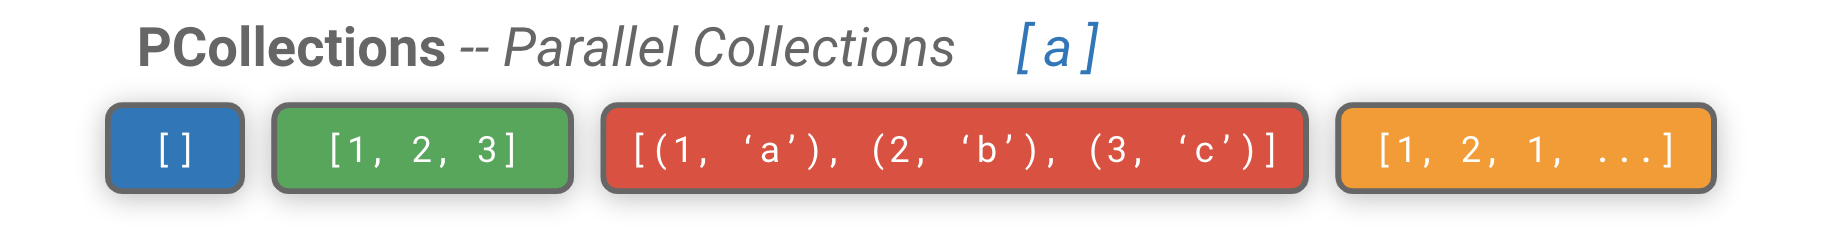

Once you have your data, the next step is to transform it.
In Beam, you transform data using **`PTransform`**s,
which stands for _Parallel Transform_.
A `PTransform` is like a __function__,
they take some inputs, transform them and create some outputs.

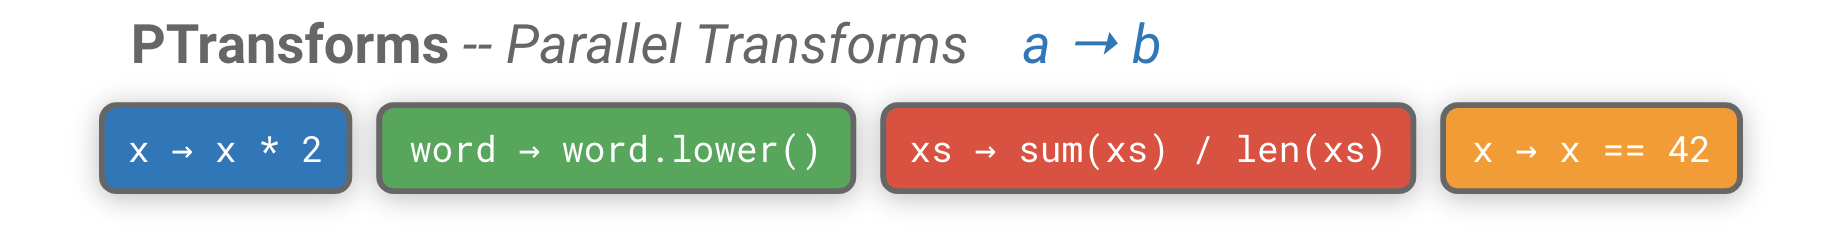

Now let's dive into creating our first pipeline.

For this first pipeline, let's just feed it some data from a Python list and print the results.

Each _step_ in the pipeline is delimited by the _pipe operator_ `|`.
The outputs of each transform are passed to the next transform as inputs.
And we can save the final results into a `PCollection` variable.

```py
# We pass the elements from step1 through step3 and save the results into `outputs`.
outputs = pipeline | step1 | step2 | step3
```

Pipelines can quickly grow long, so it's sometimes easier to read if we surround them with parentheses and break them into multiple lines.

```py
# This is equivalent to the example above.
outputs = (
  pipeline
  | step1
  | step2
  | step3
)
```

Also, Beam expects each transform, or step, to have a unique _label_, or description.
This makes it a lot easier to debug, and it's in general a good practice to start.
You can use the _right shift operator_ `>>` to add a label to your transforms, like `'My description' >> MyTransform`.

```py
# Try to give short but descriptive labels.
# These serve both as comments and help debug later on.
outputs = (
  pipeline
  | 'First step' >> step1
  | 'Second step' >> step2
  | 'Third step' >> step3
)
```

> ℹ️&nbsp; The syntax might seem a little different at first, but you'll become familiar with it.

We use the `Create` transform to feed the pipeline with an
[`iterable`](https://docs.python.org/3/glossary.html#term-iterable)
of elements, like a `list`.

Let's try to see what happens if we try to `print` a PCollection.

In [3]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

# Create a pipeline.
with beam.Pipeline() as pipeline:
  # Feed it some input elements with `Create`.
  outputs = (
      pipeline
      | 'Create initial values' >> beam.Create(inputs)
  )

  # `outputs` is a PCollection with our input elements.
  # But printing it directly won't show us its contents :(
  print(f"outputs: {outputs}")

outputs: PCollection[[3]: Create initial values/Map(decode).None]


> ℹ️&nbsp; In Beam, you can __NOT__ access the elements from a `PCollection` directly like a Python list.
> This means, we can't simply `print` the output `PCollection` to see the elements.
>
> This is because, depending on the runner,
> the `PCollection` elements might live in multiple worker machines.

To print the elements in the PCollection, we'll do a little trick, but we'll explain it shortly.

In [4]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create initial values' >> beam.Create(inputs)
  )

  # We can only access the elements through another transform.
  # Don't worry if you don't know what's happening here,
  # we'll get to it just next :)
  outputs | beam.Map(print)

0
1
2
3


# Transforming data

Apache Beam is designed with a [functional paradigm](https://en.wikipedia.org/wiki/Functional_programming).
This means that, instead of _loops_, it uses `PTransform`s alongside with _functions_ to process each element in a `PCollection`.

Let's go through some of the most common and basic data transforms in Beam.

## Map: _one-to-one_

Let's say we have some elements and we want to do something with each element.

We want to `map` a function to each element of the collection.

`map` takes a _function_ that transforms a single input `a` into a single output `b`.

> ℹ️ -- For example, we want to multiply each element by 2.

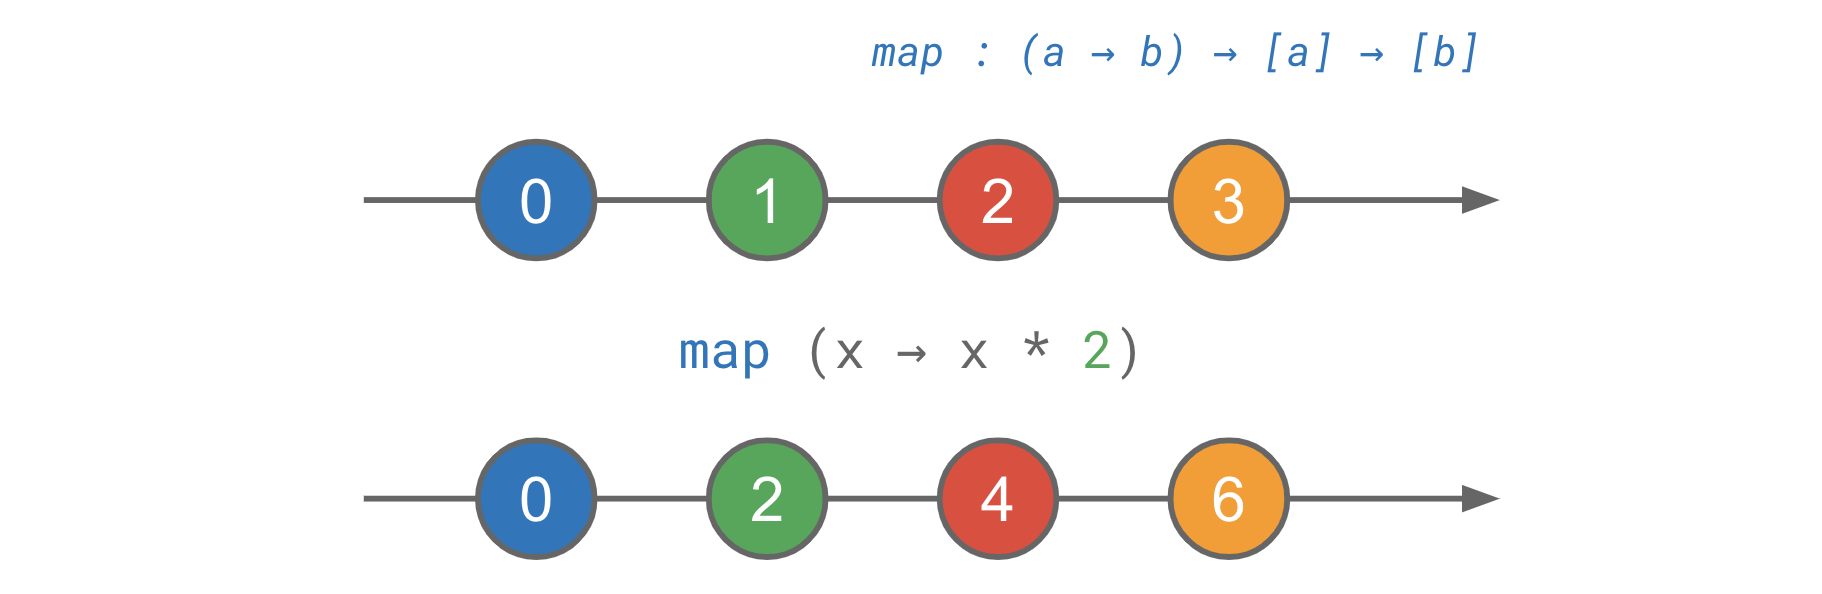

In Python, this is commonly done with the
[built-in `map` function](https://docs.python.org/3/library/functions.html#map), or with
[list comprehensions](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions).

In [5]:
inputs = [0, 1, 2, 3]

# Using the `map` function.
outputs = map(lambda x: x * 2, inputs)
print(list(outputs))

# Using a list comprehension.
outputs = [x * 2 for x in inputs]
print(outputs)

# Roughly equivalent for loop.
outputs = []
for x in inputs:
  outputs.append(x * 2)
print(outputs)

[0, 2, 4, 6]
[0, 2, 4, 6]
[0, 2, 4, 6]


In Beam, there is the
[`Map` transform](https://beam.apache.org/documentation/transforms/python/elementwise/map/),
but we must use it within a pipeline.

First we create a pipeline and feed it our input elements.
Then we _pipe_ those elements into a `Map` transform where we apply our function.

In [ ]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(inputs)
      | 'Multiply by 2' >> beam.Map(lambda x: x * 2)
  )

  outputs | beam.Map(print)

0
2
4
6


> ℹ️&nbsp; Now that we know how `Map` works, we can see what's happening when we print the elements.
>
> We have our outputs stored in the `outputs` `PCollection`, so we _pipe_ it to a `Map` transform to apply the
> [`print`](https://docs.python.org/3/library/functions.html#print)
> function.
>
> Note that `print` returns `None`, so we get an output `PCollection` of all `None` elements.
> But we are not saving its results to any variable,
> so they get discarded.
>
> This does _not_ affect the values in `outputs` in any way.

## FlatMap: _one-to-many_

`Map` allows us to transform each individual element,
but we can't change the number of elements with it.

We want to `map` a function to each element of a collection.
That function returns a _list of output elements_,
so we would get a _list of lists of elements_.
Then we want to _flatten_ the _list of lists_ into a single _list_.

`flatMap` takes a function that transforms a single input `a` into an `iterable` of outputs `b`.
But we get a _single collection_ containing the outputs of _all_ the elements.

> ℹ️ -- For example, we want to have as many elements as the element's value.
> For a value `1` we want one element, and three elements for a value `3`.

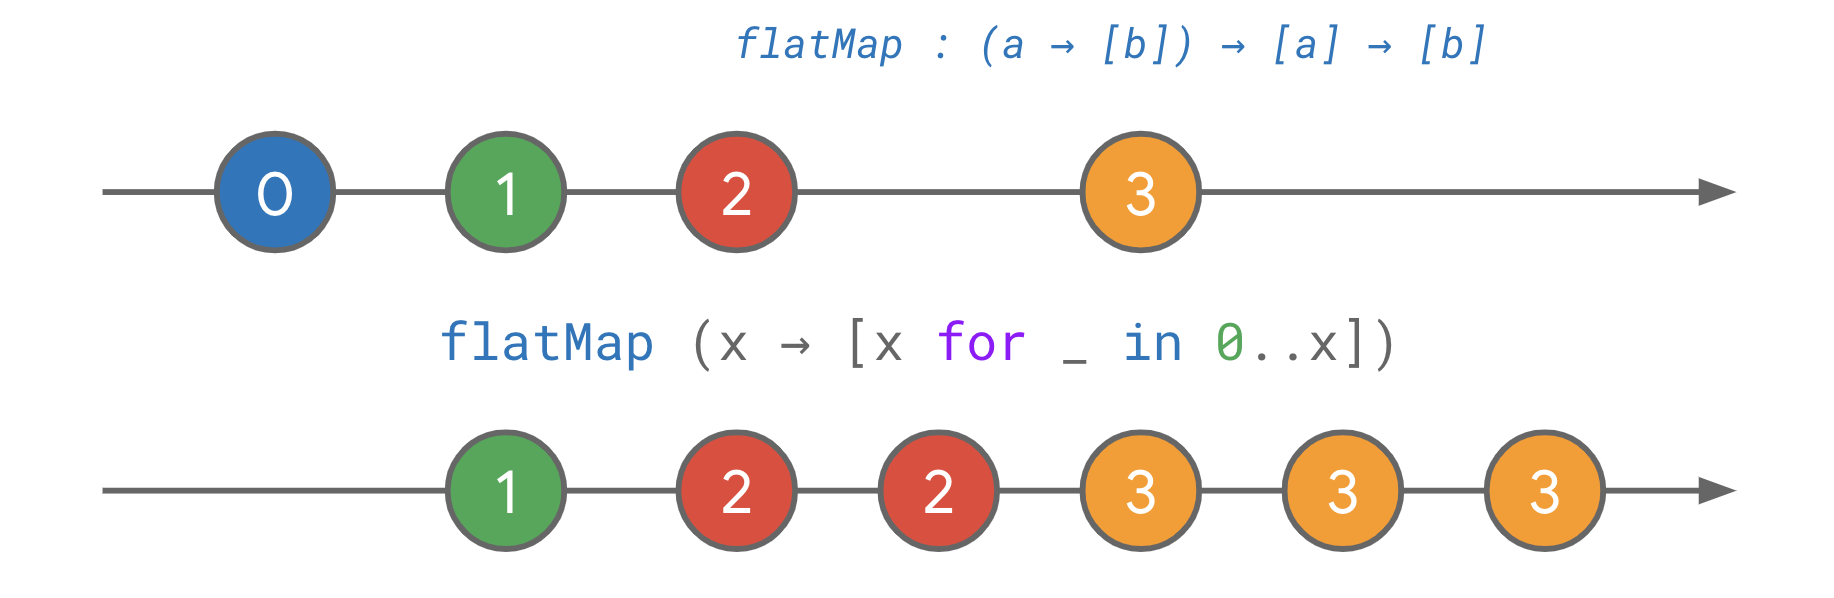

In Python this could be done with a _nested list comprehension_,
but it's a little tricky to read.

In [ ]:
inputs = [0, 1, 2, 3]

# Using a list comprehensions.
mapOutputs = [[x for _ in range(x)] for x in inputs]
# After the map function, flatten the results.
outputs = [x for xs in mapOutputs for x in xs]
print(outputs)

# Roughly equivalent for loop.
outputs = []
for x in inputs:
  outputs += [x for _ in range(x)]
print(outputs)

[1, 2, 2, 3, 3, 3]
[1, 2, 2, 3, 3, 3]


The good news is that Beam already has a
[`FlatMap` transform](https://beam.apache.org/documentation/transforms/python/elementwise/flatmap/)
built-in, so it's actually easier than plain Python.

`FlatMap` accepts a function that takes a single input element and outputs an `iterable` of elements.

In [ ]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(inputs)
      | 'Expand elements' >> beam.FlatMap(lambda x: [x for _ in range(x)])
  )

  outputs | beam.Map(print)

1
2
2
3
3
3


> ℹ️ Try replacing the `FlatMap` transform with `Map` to see how they behave differently.

## Filter: _one-to-zero_

Sometimes we want to *only* process certain elements while ignoring others.

We want to `filter` each element in a collection using a function.

`filter` takes a function that checks a single element `a`,
and returns `True` to keep the element, or `False` to discard it.

> ℹ️ -- For example, we only want to keep number that are *even*, or divisible by 2.
> We can use the
> [modulo operator `%`](https://en.wikipedia.org/wiki/Modulo_operation)
> for a simple check.

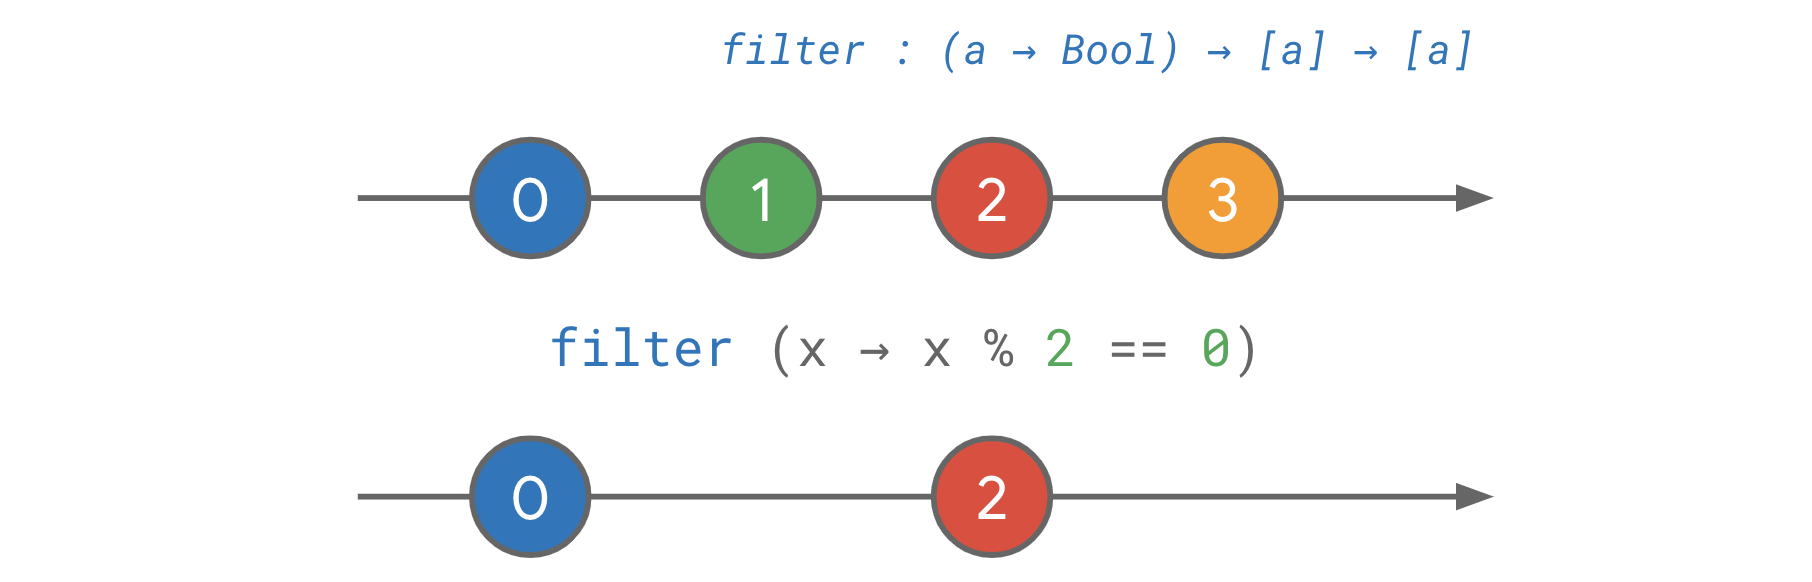

In Python we can do this with *list comprehensions* as well.

In [ ]:
inputs = [0, 1, 2, 3]

# Using a list comprehensions.
outputs = [x for x in inputs if x % 2 == 0]
print(outputs)

# Roughly equivalent for loop.
outputs = []
for x in inputs:
  if x % 2 == 0:
    outputs.append(x)
print(outputs)

[0, 2]
[0, 2]


In Beam, there is the
[`Filter` transform](https://beam.apache.org/documentation/transforms/python/elementwise/filter/).

In [ ]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(inputs)
      | 'Keep only even numbers' >> beam.Filter(lambda x: x % 2 == 0)
  )

  outputs | beam.Map(print)

0
2


## Combine: _many-to-one_

We also need a way to get a single value from an entire `PCollection`.
We might want to get the total number of elements, or the average value, or any other type of _aggregation_ of values.

We want to `combine` the elements in a collection into a single output.

`combine` takes a function that transforms an `iterable` of inputs `a`, and returns a single output `a`.

Other common names for this function are `fold` and `reduce`.

> ℹ️ -- For example, we want to add all numbers together.

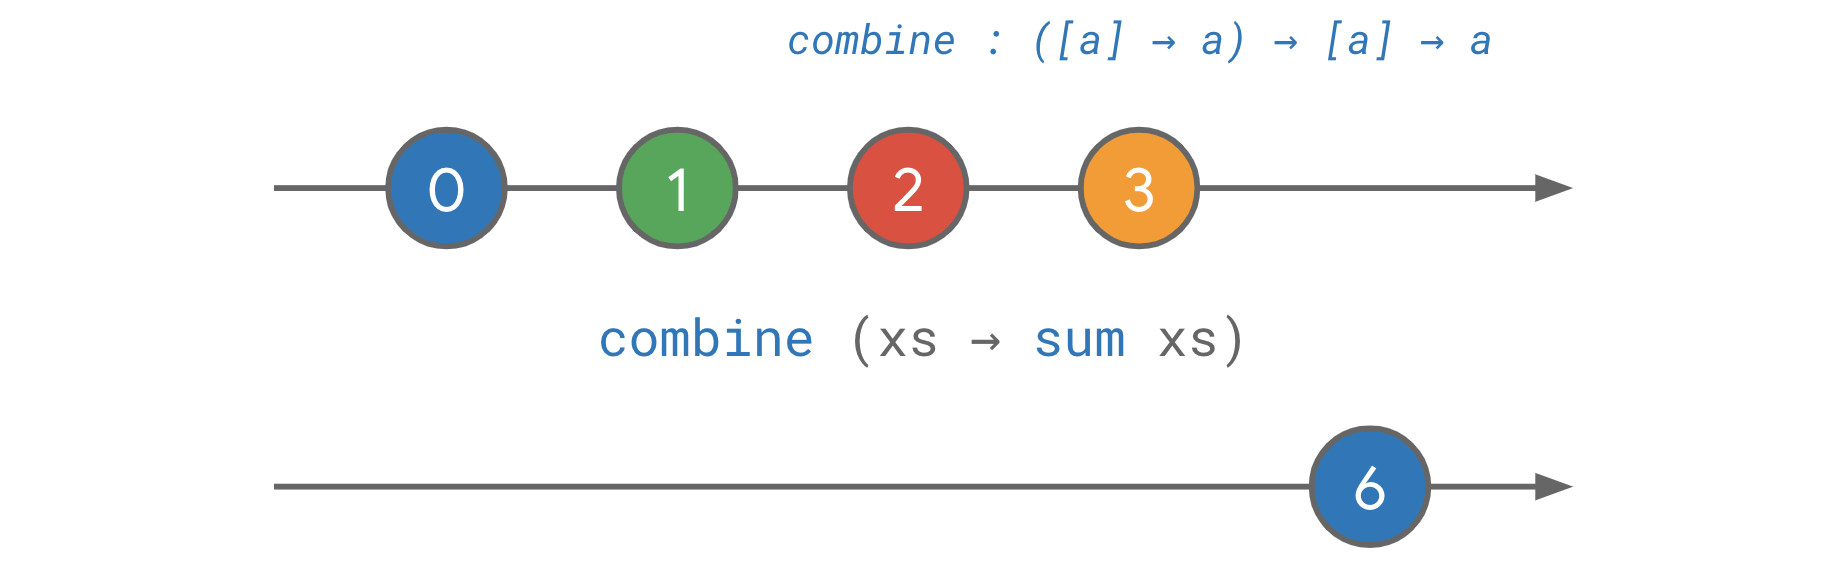

In Python this is usually achieved with the
[`reduce` function](https://docs.python.org/3/library/functools.html#functools.reduce).

In [ ]:
from functools import reduce

inputs = [0, 1, 2, 3]

# Using reduce (most general way).
output = reduce(lambda x, y: x + y, inputs, 0)
print(output)

# Using the built-in sum function, which is itself a "reduce" function.
output = sum(inputs)
print(output)

# Roughly equivalent for loop.
output = 0
for x in inputs:
  y = output
  output = x + y
print(output)

6
6
6


In Beam, there are
[aggregation transforms](https://beam.apache.org/documentation/transforms/python/overview/#aggregation).

For this particular example, we can use the
[`CombineGlobally` transform](https://beam.apache.org/documentation/transforms/python/aggregation/sum/)
which accepts a function that takes an iterable of elements as an input and outputs a single value.

We can pass the
[built-in function `sum`](https://docs.python.org/3/library/functions.html#sum)
into `CombineGlobally`.

In [ ]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(inputs)
      | 'Sum all values together' >> beam.CombineGlobally(sum)
  )

  outputs | beam.Map(print)

6


> ℹ️&nbsp; There are many ways to combine values in Beam.
> You could even combine them into a different data type by defining a custom `CombineFn`.
>
> You can learn more about them by checking the available
> [aggregation transforms](https://beam.apache.org/documentation/transforms/python/overview/#aggregation).

## GroupByKey: _group related elements_

Sometimes it's useful to pair each element with a *key* that we can use to group related elements together.

Think of it as creating a
[Python `dict`](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)
from a list of `(key, value)` pairs,
but instead of replacing the value on a "duplicate" key,
you would get a list of all the values associated with that key.

> ℹ️ -- For example, we want to group each animal with the list of foods they like, and we start with `(animal, food)` pairs.

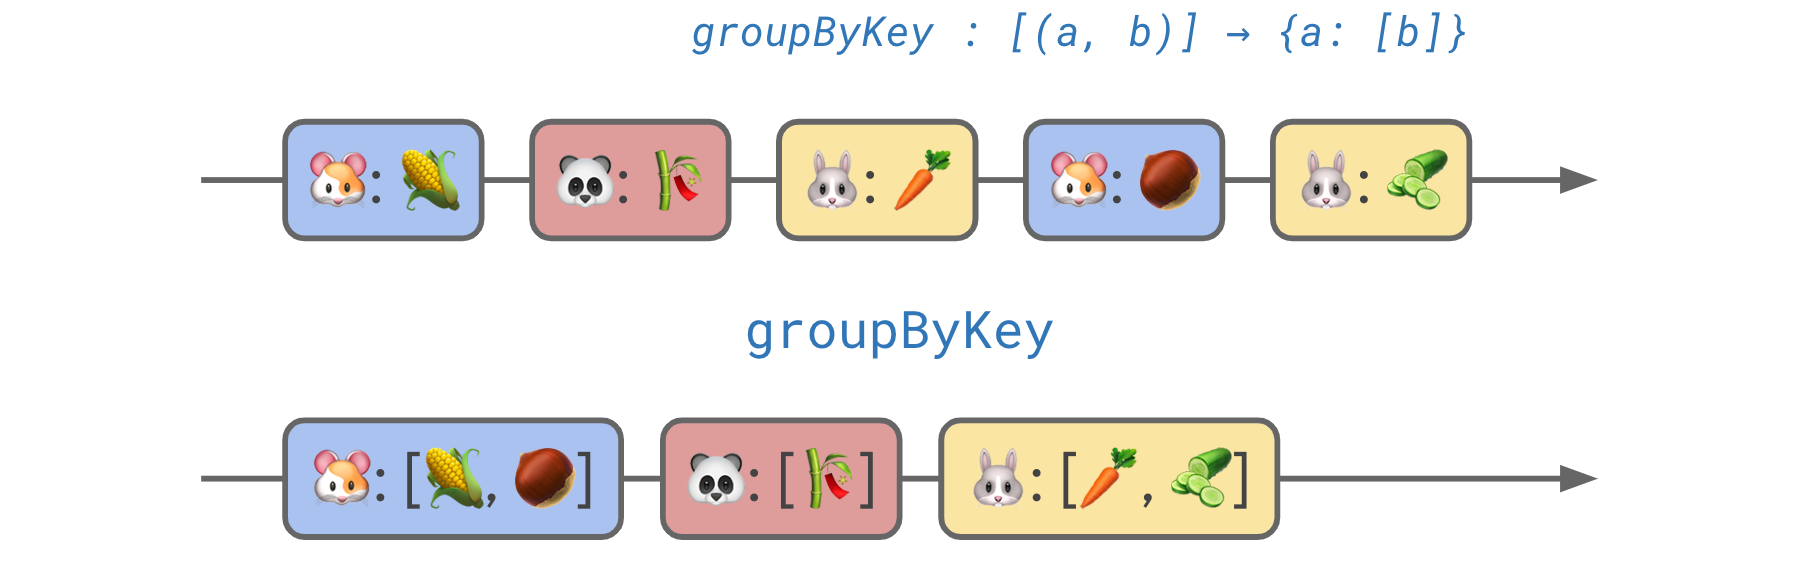

There's no built-in function for `groupByKey` in plain Python,
but here's a simple implementation.

In [ ]:
from functools import reduce

inputs = [
  ('🐹', '🌽'),
  ('🐼', '🎋'),
  ('🐰', '🥕'),
  ('🐹', '🌰'),
  ('🐰', '🥒'),
]


# Since we're getting a single dict from all the elements,
# we can use reduce for this.
def groupByKey(result, keyValue):
  key, value = keyValue
  values = result.get(key, []) + [value]
  return {**result, key: values}
output = reduce(groupByKey, inputs, {})
print(output)


# Roughly equivalent for loop.
output = {}
for key, value in inputs:
  values = output.get(key, []) + [value]
  output = {**output, key: values}
print(output)

{'🐹': ['🌽', '🌰'], '🐼': ['🎋'], '🐰': ['🥕', '🥒']}
{'🐹': ['🌽', '🌰'], '🐼': ['🎋'], '🐰': ['🥕', '🥒']}


In Beam, there is the
[`GroupByKey` transform](https://beam.apache.org/documentation/transforms/python/aggregation/groupbykey/).

In [ ]:
import apache_beam as beam

inputs = [
  ('🐹', '🌽'),
  ('🐼', '🎋'),
  ('🐰', '🥕'),
  ('🐹', '🌰'),
  ('🐰', '🥒'),
]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create (animal, food) pairs' >> beam.Create(inputs)
      | 'Group foods by animals' >> beam.GroupByKey()
  )

  outputs | beam.Map(print)

('🐹', ['🌽', '🌰'])
('🐼', ['🎋'])
('🐰', ['🥕', '🥒'])


# What's next?

* [Transform catalog](https://beam.apache.org/documentation/transforms/python/overview/) -- check out all the available transforms
* [Using I/O transforms](https://beam.apache.org/documentation/programming-guide/#pipeline-io) -- learn how to read/write data to/from external sources and sinks like text files or databases
* [Mobile gaming example](https://beam.apache.org/get-started/mobile-gaming-example/) -- learn more about windowing, triggers, and streaming through a complete example pipeline
* [Runners](https://beam.apache.org/documentation/runners/capability-matrix/) -- check the available runners, their capabilities, and how to run your pipeline in them